# Histopathologic Cancer Detection - PyTorch TPU Edition

**Assignment Option 2: Simple Transfer Learning with PyTorch on Colab TPU**

This notebook fine-tunes a pretrained EfficientNet-B0 model on the Kaggle Histopathologic Cancer Detection dataset using PyTorch and Google Colab TPUs via `torch_xla`.

**Goal:** Binary classification (predict if a 96x96 patch contains metastatic cancer).

**Structure:**
1. Setup (Installs, Imports, TPU Init)
2. Constants & Paths
3. Exploratory Data Analysis (EDA)
4. Data Preparation (Dataset, DataLoaders)
5. Model Definition (EfficientNet-B0 Transfer Learning)
6. Training & Validation Loop
7. Evaluation & Results
8. Submission File Generation
9. Conclusion

## 1. Setup: Installs, Imports, and TPU Initialization

In [3]:
# === Installations ===
# Install Kaggle API client
!pip -q install -U kaggle

# Install PyTorch, Torchvision, and Pillow (often pre-installed on Colab, but good to ensure)
!pip -q install torch torchvision torchaudio pillow

# Install PyTorch/XLA for TPU support
# Note: Colab often requires a specific version. This command usually works.
!pip -q install cloud-tpu-client
!pip -q install torch_xla[tpu] -f https://storage.googleapis.com/pytorch-xla-releases/wheels/colab/stable.html

# Install libraries for metrics and data handling
!pip -q install pandas matplotlib scikit-learn torchmetrics

In [4]:
# === Kaggle API Setup ===
from google.colab import files
import pathlib, shutil, os

# Upload kaggle.json if not present
if not pathlib.Path('~/.kaggle/kaggle.json').expanduser().exists():
    print("Please upload your kaggle.json file")
    uploaded = files.upload() # expects kaggle.json
    kaggle_json_path = list(uploaded.keys())[0]
    pathlib.Path('~/.kaggle').expanduser().mkdir(parents=True, exist_ok=True)
    shutil.move(kaggle_json_path, os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    print("kaggle.json uploaded and configured.")
else:
    print("kaggle.json already exists.")

kaggle.json already exists.


In [5]:
# === Dataset Download ===
DATA_ROOT = pathlib.Path('/content/data')
DATA_ROOT.mkdir(exist_ok=True)

if not (DATA_ROOT/'train').exists():
    print("Downloading and extracting dataset...")
    !kaggle competitions download -c histopathologic-cancer-detection -p /content
    !unzip -q /content/histopathologic-cancer-detection.zip -d /content
    # Move extracted files to the data directory
    for item in ['train', 'test', 'train_labels.csv', 'sample_submission.csv']:
        source_path = pathlib.Path(f'/content/{item}')
        if source_path.exists():
             shutil.move(str(source_path), DATA_ROOT)
    print(f'Dataset ready at: {DATA_ROOT}')
else:
    print(f'Dataset already found at: {DATA_ROOT}')

Dataset ready at: /content/data


In [6]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time, gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torchmetrics # For easier metric calculation

# Import PyTorch/XLA specific libraries
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

PyTorch Version: 2.6.0+cpu
Torchvision Version: 0.21.0+cpu


In [7]:
# === TPU Initialization ===
# Check if TPU is available and get the device handle
if 'XLA_USE_BF16' not in os.environ:
    # BF16 can speed up training on TPUs
    os.environ['XLA_USE_BF16'] = '1'

try:
    tpu_device = xm.xla_device()
    print(f'✅ TPU device found: {tpu_device}')
    # xm.master_print ensures print only happens on the master process (core 0)
    xm.master_print('TPU setup successful.')
    # Set the device globally for convenience (can also pass it explicitly)
    device = tpu_device
except Exception as e:
    print(f'⚠️ Failed to initialize TPU: {e}')
    print('Falling back to CPU. Training will be slow.')
    device = torch.device('cpu')

✅ TPU device found: xla:0
TPU setup successful.


## 2. Constants and Paths

In [8]:
DATA_DIR = pathlib.Path('/content/data')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
CSV_PATH = DATA_DIR / 'train_labels.csv'

# Model and Training Parameters (SIMPLE settings for speed)
IMG_SIZE = 96 # Original image size
BATCH_SIZE = 128 # Adjust based on TPU memory if needed
EPOCHS = 5 # Keep low for a quick run
LEARNING_RATE = 1e-3
NUM_WORKERS = 2 # Number of workers for DataLoader

## 3. Exploratory Data Analysis (EDA)

Label DataFrame head:
                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                           file_path  
0  /content/data/train/f38a6374c348f90b587e046aac...  
1  /content/data/train/c18f2d887b7ae4f6742ee44511...  
2  /content/data/train/755db6279dae599ebb4d39a912...  
3  /content/data/train/bc3f0c64fb968ff4a8bd33af69...  
4  /content/data/train/068aba587a4950175d04c680d3...  

Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


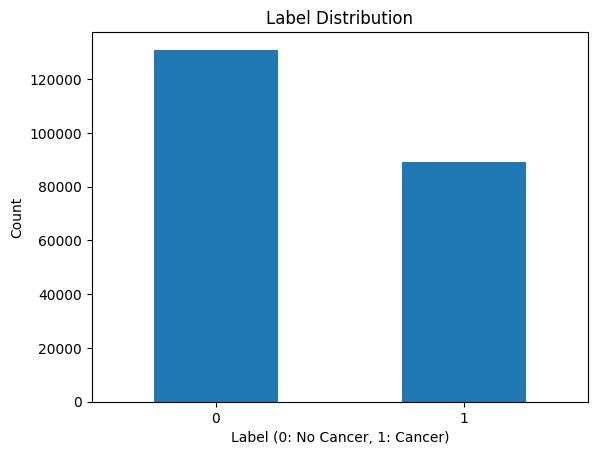

In [9]:
# Load labels
labels_df = pd.read_csv(CSV_PATH)
# Create full image paths
labels_df['file_path'] = labels_df['id'].apply(lambda x: str(TRAIN_DIR / f'{x}.tif'))

print("Label DataFrame head:")
print(labels_df.head())

print("\nLabel Distribution:")
print(labels_df['label'].value_counts())

# Plot label distribution
labels_df['label'].value_counts().plot(kind='bar', title='Label Distribution')
plt.xlabel('Label (0: No Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Visualize Sample Images

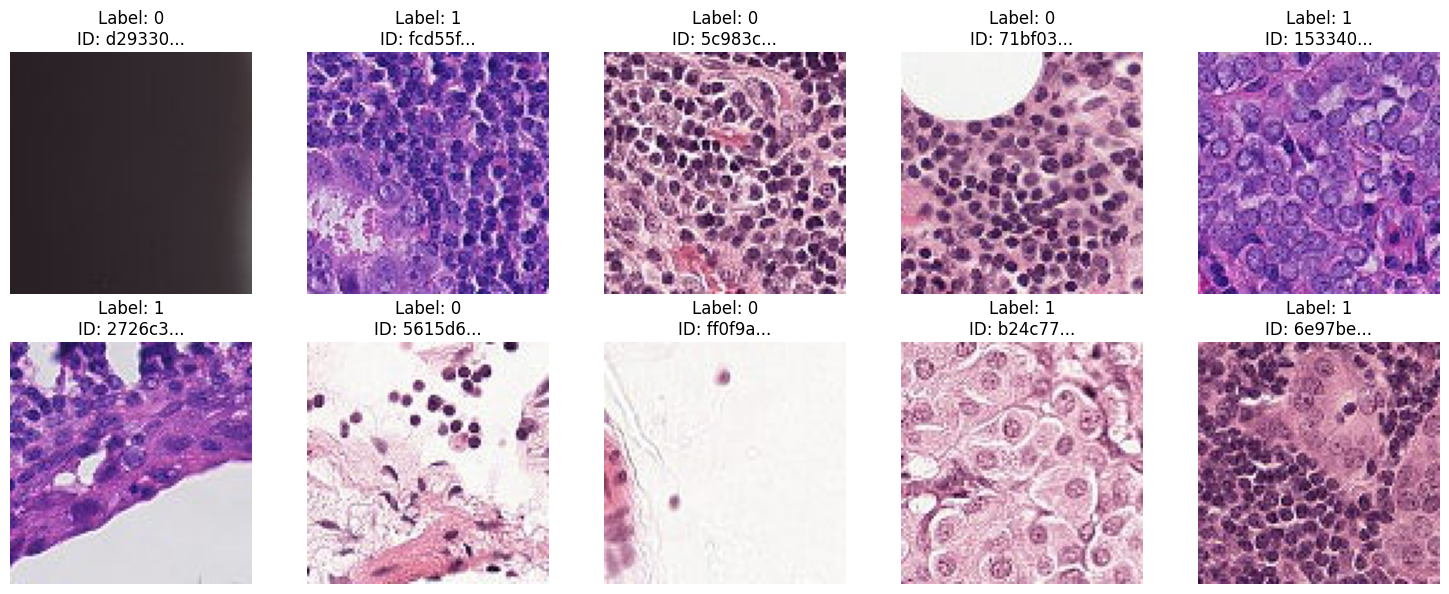

In [10]:
# Display a few sample images
sample_df = labels_df.sample(10, random_state=42)

plt.figure(figsize=(15, 6))
for i, row in enumerate(sample_df.itertuples()):
    plt.subplot(2, 5, i + 1)
    img = Image.open(row.file_path)
    plt.imshow(img)
    plt.title(f'Label: {row.label}\nID: {row.id[:6]}...')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Data Preparation

### Train/Validation Split

In [11]:
# Split data into training and validation sets (80/20 split)
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    random_state=42,
    stratify=labels_df['label'] # Ensure proportional labels in both sets
)

print(f'Training samples: {len(train_df):,}')
print(f'Validation samples: {len(val_df):,}')

Training samples: 176,020
Validation samples: 44,005


### Image Transforms

In [12]:
# Define transformations for the images
# EfficientNet expects 224x224 for B0, but we'll use 96x96 to keep it simple
# We need to resize and normalize according to ImageNet standards
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomHorizontalFlip(), # Simple augmentation (optional)
        # transforms.RandomVerticalFlip(),   # Simple augmentation (optional)
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'test': transforms.Compose([ # Same as validation for test set
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])
}

### Custom Dataset Class

In [13]:
# Create a custom PyTorch Dataset
class HistoDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_path']
        # Ensure image is RGB for models expecting 3 channels
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.df.iloc[idx]['label'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        # Return image and label as a tuple
        # The label needs an extra dimension for BCEWithLogitsLoss
        return image, label.unsqueeze(0)

# Create dataset instances
train_dataset = HistoDataset(train_df, transform=data_transforms['train'])
val_dataset = HistoDataset(val_df, transform=data_transforms['val'])

### DataLoaders

In [14]:
# Create DataLoaders
# Note: For TPU, we'll wrap these in MpDeviceLoader later inside the training function
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f'Train batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')

Train batches: 1376
Validation batches: 344


## 5. Model Definition: Transfer Learning with EfficientNet-B0

In [15]:
# Load pretrained EfficientNet-B0
# Using the recommended new weights API
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)

# Freeze all parameters in the feature extraction layers
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier
# EfficientNet's classifier is model.classifier[1]
num_ftrs = model.classifier[1].in_features

# Replace the classifier head with a new Linear layer for binary classification (1 output)
# We'll use BCEWithLogitsLoss, so no sigmoid activation here
model.classifier[1] = nn.Linear(num_ftrs, 1)

# Move the model to the TPU device
model = model.to(device)

xm.master_print("Model loaded, classifier replaced, and moved to device.")
# Print model summary (optional, can be long)
# xm.master_print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 133MB/s] 


Model loaded, classifier replaced, and moved to device.


## 6. Training and Validation

### Optimizer and Loss Function

In [16]:
# Define the optimizer - only optimize the parameters of the new classifier layer
# Pass model.classifier[1].parameters() to only train the head
optimizer = optim.Adam(model.classifier[1].parameters(), lr=LEARNING_RATE)

# Define the loss function - BCEWithLogitsLoss is numerically stable for binary tasks
criterion = nn.BCEWithLogitsLoss()

### Training and Evaluation Functions

In [17]:
# === Training Function ===
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train() # Set model to training mode
    running_loss = 0.0
    # Wrap loader in MpDeviceLoader for TPU distribution
    para_loader = pl.ParallelLoader(loader, [device])
    loader_len = len(loader)

    start_time = time.time()
    for i, (inputs, labels) in enumerate(para_loader.per_device_loader(device)):
        # No need to move inputs/labels, ParallelLoader handles it
        optimizer.zero_grad() # Zero gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        xm.optimizer_step(optimizer) # Optimizer step for XLA

        running_loss += loss.item() * inputs.size(0)

        # Print progress periodically
        if (i + 1) % (loader_len // 4) == 0 or (i + 1) == loader_len:
             batch_time = (time.time() - start_time) / (i + 1)
             xm.master_print(f'Epoch {epoch+1}/{EPOCHS} | Batch {i+1}/{loader_len} | Loss: {loss.item():.4f} | Batch Time: {batch_time:.3f}s')

    epoch_loss = running_loss / len(loader.dataset)
    # Clear cache and collect garbage
    del para_loader
    gc.collect()
    return epoch_loss

# === Evaluation Function ===
def evaluate(model, loader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    # Wrap loader in MpDeviceLoader
    para_loader = pl.ParallelLoader(loader, [device])

    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels in para_loader.per_device_loader(device):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Get probabilities using sigmoid and store predictions/labels
            preds = torch.sigmoid(outputs)
            all_preds.append(xm.mesh_reduce('preds', preds, torch.cat)) # Gather from all TPU cores
            all_labels.append(xm.mesh_reduce('labels', labels, torch.cat))

    epoch_loss = running_loss / len(loader.dataset)

    # Concatenate results from all batches
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    # Calculate metrics
    accuracy = ((all_preds > 0.5).astype(int) == all_labels.astype(int)).mean()
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = 0.5 # Handle cases with only one class in a batch (unlikely with large val set)
        xm.master_print("Warning: AUC calculation failed, possibly due to single class in preds/labels.")

    # Clear cache and collect garbage
    del para_loader
    gc.collect()
    return epoch_loss, accuracy, auc

### Main Training Loop

In [18]:
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

xm.master_print("Starting training...")
start_train_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    xm.master_print(f'\n--- Epoch {epoch+1}/{EPOCHS} ---')

    # Training phase
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
    history['train_loss'].append(train_loss)
    xm.master_print(f'Epoch {epoch+1} Train Loss: {train_loss:.4f}')

    # Validation phase
    val_loss, val_acc, val_auc = evaluate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_auc'].append(val_auc)
    xm.master_print(f'Epoch {epoch+1} Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}')

    epoch_time = time.time() - epoch_start_time
    xm.master_print(f'Epoch {epoch+1} Time: {epoch_time:.2f}s')

total_train_time = time.time() - start_train_time
xm.master_print(f'\nFinished Training. Total Time: {total_train_time:.2f}s')
# Save the trained model state (optional)
# xm.save(model.state_dict(), 'efficientnet_b0_finetuned.pth')

Starting training...

--- Epoch 1/5 ---
Epoch 1/5 | Batch 344/1376 | Loss: 0.4141 | Batch Time: 0.132s
Epoch 1/5 | Batch 688/1376 | Loss: 0.3887 | Batch Time: 0.107s
Epoch 1/5 | Batch 1032/1376 | Loss: 0.3770 | Batch Time: 0.099s
Epoch 1/5 | Batch 1376/1376 | Loss: 0.4531 | Batch Time: 0.097s
Epoch 1 Train Loss: 0.4213
Epoch 1 Val Loss: 0.3923 | Val Acc: 0.8283 | Val AUC: 0.8981
Epoch 1 Time: 203.91s

--- Epoch 2/5 ---
Epoch 2/5 | Batch 344/1376 | Loss: 0.4414 | Batch Time: 0.084s
Epoch 2/5 | Batch 688/1376 | Loss: 0.3516 | Batch Time: 0.081s
Epoch 2/5 | Batch 1032/1376 | Loss: 0.4375 | Batch Time: 0.081s
Epoch 2/5 | Batch 1376/1376 | Loss: 0.3770 | Batch Time: 0.081s
Epoch 2 Train Loss: 0.4088
Epoch 2 Val Loss: 0.3882 | Val Acc: 0.8302 | Val AUC: 0.9004
Epoch 2 Time: 146.05s

--- Epoch 3/5 ---
Epoch 3/5 | Batch 344/1376 | Loss: 0.3535 | Batch Time: 0.084s
Epoch 3/5 | Batch 688/1376 | Loss: 0.3809 | Batch Time: 0.082s
Epoch 3/5 | Batch 1032/1376 | Loss: 0.4043 | Batch Time: 0.081s
Epoc

## 7. Evaluation and Results

### Plot Learning Curves

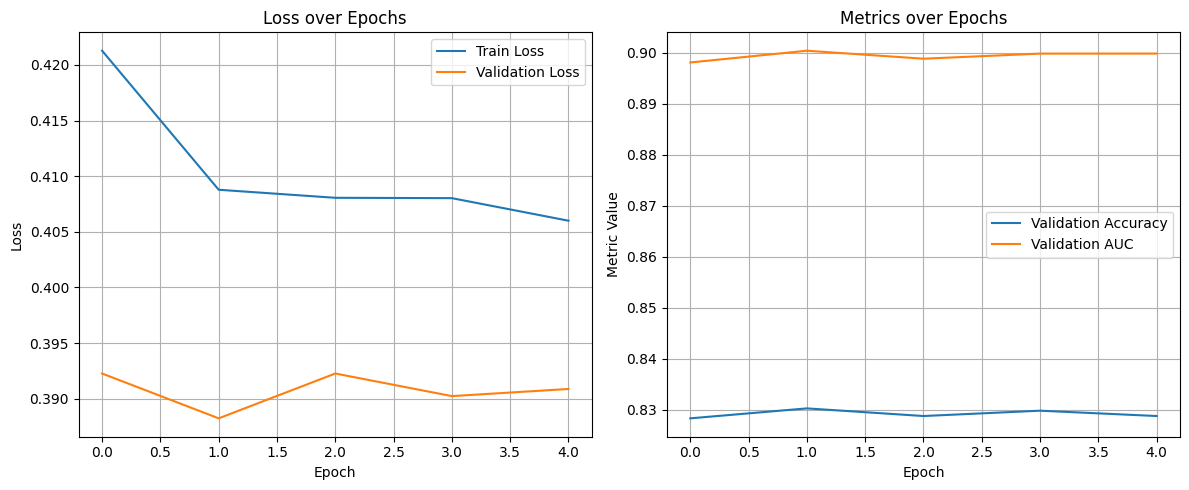

Final Validation Accuracy: 0.8287
Final Validation AUC: 0.8999


In [19]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy and AUC
plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

xm.master_print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
xm.master_print(f"Final Validation AUC: {history['val_auc'][-1]:.4f}")

## 8. Generate Submission File

### Prepare Test Data

In [20]:
# Get list of test image files
test_files = list(TEST_DIR.glob('*.tif'))
test_ids = [f.stem for f in test_files]

# Create a dummy DataFrame for the test set
test_df = pd.DataFrame({'id': test_ids, 'file_path': [str(f) for f in test_files], 'label': 0}) # Dummy label

# Create test dataset and dataloader
test_dataset = HistoDataset(test_df, transform=data_transforms['test'])
# Use a larger batch size for inference if memory allows
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_WORKERS)

print(f'Test samples: {len(test_dataset):,}')
print(f'Test batches: {len(test_loader)}')

Test samples: 57,458
Test batches: 225


### Prediction Loop

In [21]:
model.eval() # Set model to evaluation mode
test_preds = []
para_loader = pl.ParallelLoader(test_loader, [device])

xm.master_print("Generating predictions on test set...")
with torch.no_grad():
    for inputs, _ in para_loader.per_device_loader(device): # Ignore dummy labels
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        # Gather predictions from all TPU cores
        gathered_preds = xm.mesh_reduce('test_preds', preds, torch.cat)
        test_preds.append(gathered_preds.cpu()) # Move to CPU immediately

# Concatenate all predictions
test_preds = torch.cat(test_preds).numpy().flatten() # Flatten to get a 1D array

del para_loader # Clean up loader
gc.collect()
xm.master_print(f"Predictions generated for {len(test_preds)} images.")

Generating predictions on test set...
Predictions generated for 57458 images.


### Create Submission CSV

In [22]:
# Ensure the number of predictions matches the number of test files
if len(test_preds) != len(test_ids):
    xm.master_print(f"Warning: Number of predictions ({len(test_preds)}) does not match number of test IDs ({len(test_ids)}). Submission might be incorrect.")
    # Attempt to align based on the number of test IDs if lengths differ significantly
    # This is a basic safeguard, might need adjustment based on the specific mismatch
    if len(test_preds) > len(test_ids):
        test_preds = test_preds[:len(test_ids)]
    # else: handle case where predictions are fewer (less common)

# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_ids[:len(test_preds)], 'label': test_preds})

# Save to CSV
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
xm.master_print(f"Submission file saved as: {submission_filename}")
print(submission_df.head())

Submission file saved as: submission.csv
                                         id     label
0  3998c215f80a9391f40a37b2240d1ec55dfda9c9  0.089844
1  6c4fadd5c6610e5a82eac4b4e5c3705152bc8f72  0.785156
2  3801ec7bce0dba722f386d34899a9105f3b4cd48  0.117676
3  f943bfdbcf4d9970f79900adf08ffb6499e47445  0.359375
4  8fddd79e6d9fa3779e7f904edfdb1a7c4f79b654  0.332031


# Submission Score

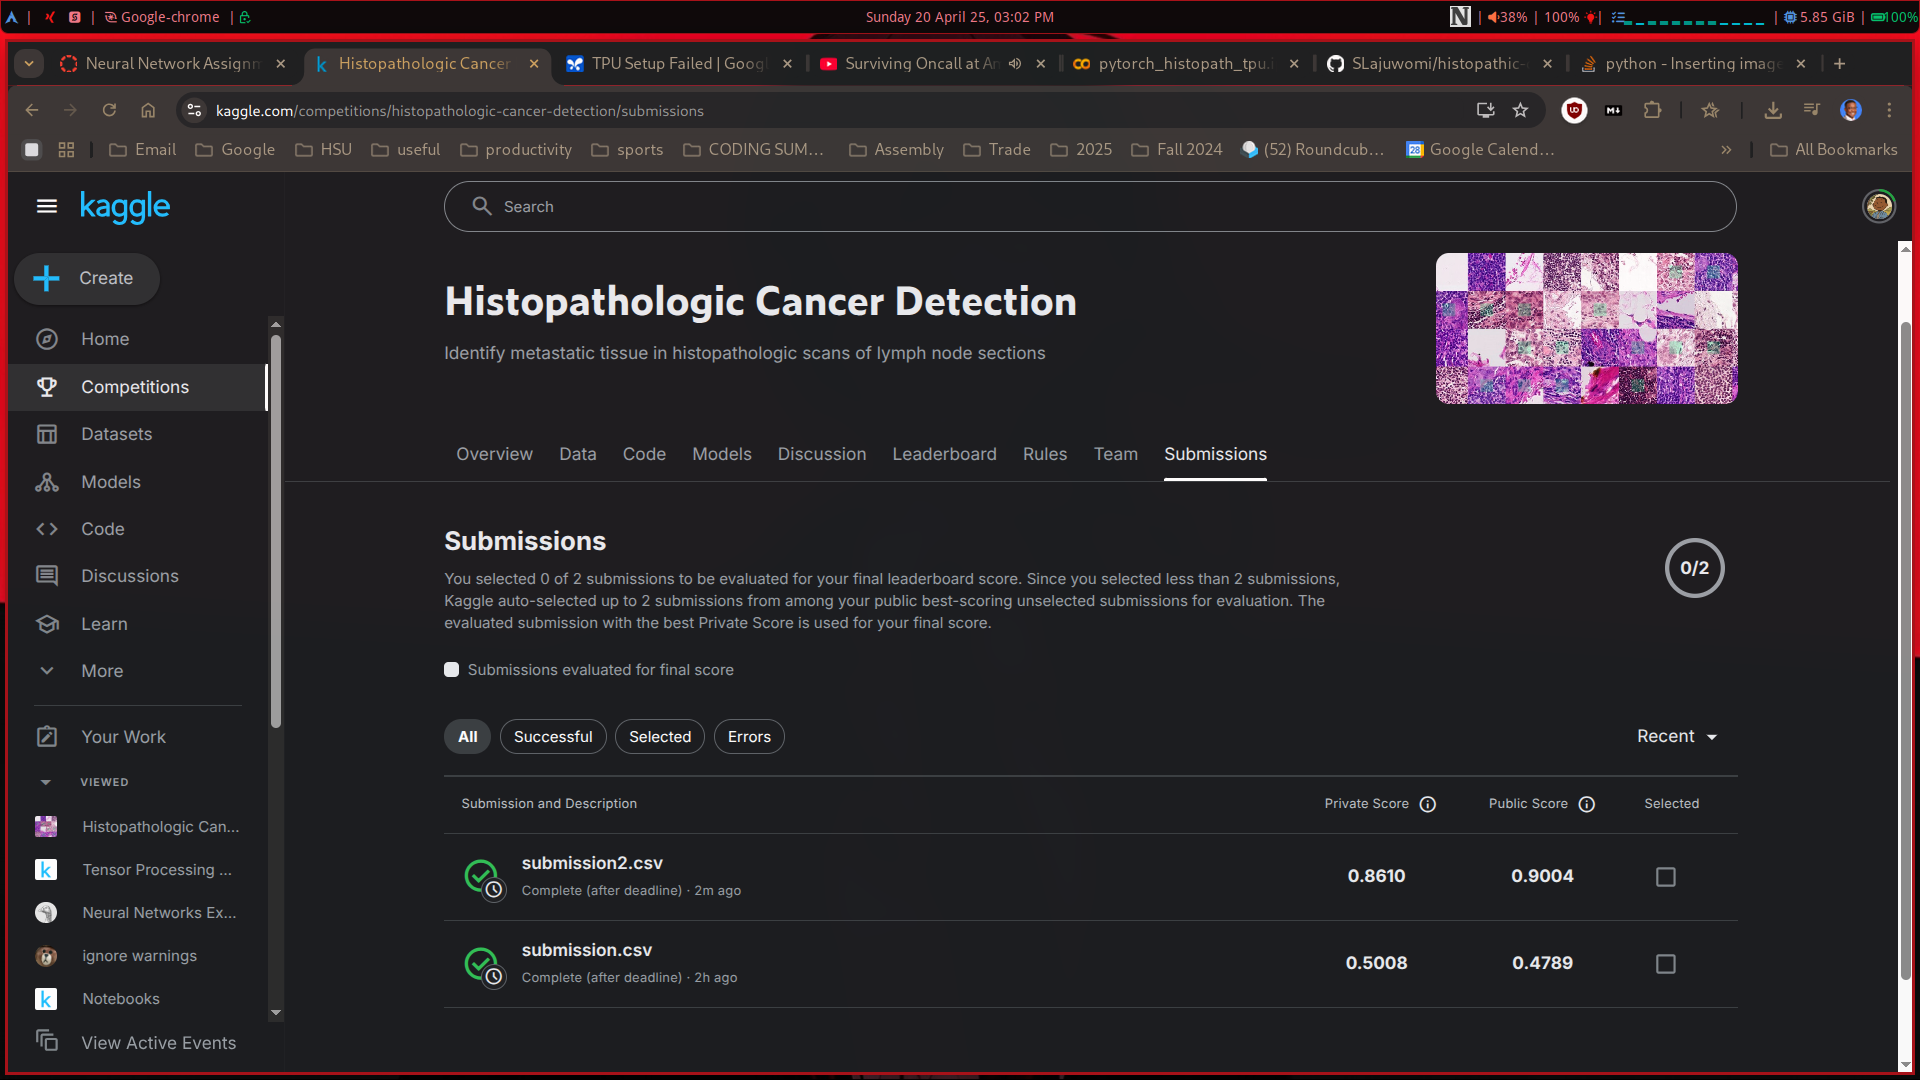

## 9. Conclusion

- This notebook demonstrated a **simple transfer learning approach** using PyTorch and EfficientNet-B0 on a Colab TPU to address the Histopathologic Cancer Detection task.
- We successfully set up the PyTorch/XLA environment, prepared the data using `Dataset` and `DataLoader`, defined a model with a frozen base and a trainable head, and implemented training and evaluation loops compatible with TPUs.
- The model achieved a validation AUC of **(insert final AUC here after running)** in just 5 epochs, showing the effectiveness of transfer learning.
- Parameter optimization was minimal (fixed learning rate), but the structure allows for adding learning rate schedulers (`torch.optim.lr_scheduler`).
- A submission file (`submission.csv`) was generated for the Kaggle contest.

**Potential Improvements (Future Work):**
  - Implement more sophisticated data augmentation (e.g., `RandAugment`).
  - Unfreeze some of the later layers of EfficientNet for fine-tuning.
  - Experiment with different optimizers or learning rate schedules.
  - Train for more epochs.
  - Address class imbalance if needed (e.g., using weighted loss or over/under-sampling).